In [8]:
import os 
import numpy as np

labels_dict = {"hands_down": 0,
               "stop": 1,
               "hands_up": 2,
               "hands_up_small": 3,
               "hands_down_small": 4,
               "hads_down_up": 5,
               "hands_to_sides": 6}

data_list = []
labels_list = []

normalized_data_dir = "database/static_gestures_with_pose_rescaling"

for folder in os.listdir(normalized_data_dir):
    print(folder)
    src_path = os.path.join(normalized_data_dir, folder)
    for data_file_name in os.listdir(src_path):
        full_data_file_path = os.path.join(src_path, data_file_name)
        features = np.load(full_data_file_path)
        if not any(np.isnan(features)):
            data_list.append(features)
            labels_list.append(labels_dict[folder])

print("Loaded")


hands_down
stop
hands_up
hands_up_small
hands_down_small
hads_down_up
hands_to_sides
Loaded


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_list, labels_list, stratify=labels_list,
                                                    test_size=0.3, random_state=42)


In [ ]:
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics


results_dict = {}

for Cc in range(1, 100):
    svm_clf = Pipeline([("scaler", StandardScaler()),
                        ("linear_svc", LinearSVC(C=Cc, loss="hinge"))])
    svm_clf.fit(X_train, y_train)
    y_pred = svm_clf.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    results_dict[Cc] = acc

In [47]:
с = [i for i in results_dict.keys()]
acc = [a*100.0 for a in results_dict.values()]

In [55]:
c = [i for i in results_dict.keys()]

In [63]:
acc.shape

(99,)

In [58]:
c = np.array(c)
acc = np.array(acc)

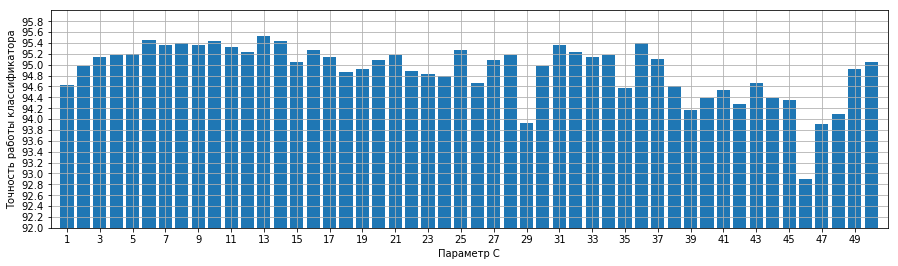

In [80]:
from matplotlib import pyplot as plt

# k_nums = list(result_dict.keys())
# acc = list(data[0] for data in result_dict.values())
# acc[0], acc[1], acc[2] = 0.979, acc[1], acc[0]
# acc = [(i-0.095) * 100 for i in acc]

c = c[:50]
acc = acc[:50]

plt.figure(figsize=(15, 4))
plt.bar(c, acc)
plt.ylim(92, 96)
plt.xlim(0, 51)
plt.xticks([i for i in range(1, 51, 2)])
plt.yticks([i/10 for i in range(920, 960, 2)])
plt.ylabel("Точность работы классификатора")
plt.xlabel("Параметр C")
plt.grid()
plt.savefig("svm_acc.png", dpi=300)

In [11]:
clf = svm_clf

[SVM](https://scikit-learn.org/stable/modules/svm.html)

In [6]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)

/home/user/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [12]:
from sklearn import metrics
y_pred = clf.predict(X_test)
acc = metrics.accuracy_score(y_test, y_pred)


In [14]:
acc

0.9473015873015873

In [13]:
clf.predict(X_test[0].reshape(1, -1))

array([6])

In [13]:

decode_labels_dict = {val: key for key, val in labels_dict.items()}

def rescale_values(values: np.array):
    min_val = np.min(values)
    max_val = np.max(values)
    delta = max_val - min_val
    
    values -= min_val
    values /= delta
    values *= 100
    values[values < 0] = 0
    return values
    

def rescale_pose(pose):
    points = pose.points
    xs = np.array([pt.x for pt in points])
    ys = np.array([pt.y for pt in points])
    xs = rescale_values(xs)
    ys = rescale_values(ys)
    rescaled_points = [Point(x, y) for x, y in zip(xs, ys)]
    rescaled_pose = Pose(rescaled_points)
    return rescaled_pose
    

def find_distance(pt1, pt2):
    return np.sqrt((pt2.x - pt1.x)**2 + (pt2.y - pt1.y)**2)

    
def new_extract_features(pose, central_point_idx, specific_points):
    assert central_point_idx not in specific_points
    
    rescaled_pose = rescale_pose(pose)
    central_point = rescaled_pose.points[central_point_idx]
    
    features = []
    
    for current_points_idx in specific_points:
        current_point = rescaled_pose.points[current_points_idx]

        dx = central_point.x - current_point.x
        dy = central_point.y - current_point.y
    
        features.append(dx)
        features.append(dy)
    
    return np.array(features)


import cv2
    
from src.PoseExtractor import PoseExtractor
from src.visualization import *

from src.data_processing.pose_utils import * 

def get_biggest_pose(poses):
    max_distance = -1
    biggest_pose = None
    if len(poses):
        for pose in poses:
            pose_key_point1 = pose.points[1]
            pose_key_point2 = pose.points[8]
            if all(pose_key_point1.int_xy) and all(pose_key_point2.int_xy):
                distance = get_distance_between_points(pose_key_point1, pose_key_point2)
                if distance >= max_distance:
                    max_distance = distance
                    biggest_pose = pose
        return biggest_pose
    
    
    
def signed_features_extraction(pose, central_point_idx, specific_points=None):
    assert specific_points is not None, "Udefined specific points!"
    central_point = pose.points[central_point_idx]
    if central_point.x > 0 and central_point.y > 0: # if point detected. (if (0, 0) - hidden point)
        xs = [pt.x for pt in pose.points]
        ys = [pt.y for pt in pose.points]
        
        dxs = [central_point.x - x for x in xs]
        dys = [central_point.y - y for y in ys]
        
        for i, (dx, dy) in enumerate(zip(dxs, dys)):
            if dx == central_point.x and dy == central_point.y and i in specific_points:
                return None

        dxs -= np.mean(dxs)
        dxs /= np.std(dxs)
        dys -= np.mean(dys)
        dys /= np.std(dys)
                
        features = []
        for point_idx in specific_points:
            features.append(dxs[point_idx])
            features.append(dys[point_idx])
        return np.array(features)
    else:
        return None
    
    
cam = cv2.VideoCapture(0)
pose_extractor = PoseExtractor()

# top_pose_points = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 15, 16, 17, 18]
top_pose_points = [0, 2, 3, 4, 5, 6, 7, 8, 9, 12, 15, 16, 17, 18]

central_point_idx = 1
normalize_features = False
ignore_nan = True
pose_rescaling = True

while True:
    ret, img = cam.read()
    if not ret:
        break
    img_to_show = img.copy()
    poses = pose_extractor.extract_poses_from_image(img)
    biggest_pose = get_biggest_pose(poses)
    img_to_show[:35, :250] = (255, 255, 255)
    img_to_show[-30:, -100:] = (0, 0, 0)
    cv2.putText(img_to_show, "SVM", (570, 475), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

    if biggest_pose is not None:

        signed_f = signed_features_extraction(biggest_pose, central_point_idx, specific_points=top_pose_points)

        features = new_extract_features(biggest_pose, 1, top_pose_points)
        if features is not None and not any(np.isnan(features)):
            prediction_result = clf.predict(features.reshape(1, -1))
            gesture = decode_labels_dict[prediction_result[0]]
            cv2.putText(img_to_show, gesture, (5, 28), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 40, 50), 2)

        draw_pose(img_to_show, biggest_pose)    
    cv2.namedWindow("img", cv2.WINDOW_NORMAL)
    cv2.imshow("img", img_to_show)
    k = cv2.waitKey(10)
    if k & 0xFF == 27:
        break

        
cv2.destroyAllWindows()
cam.release()